[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/corazzon/boostcourse-ds-511/blob/master/pima-regression-baseline-01.ipynb)

## 데이터셋 출처
* [Pima Indians Diabetes Database | Kaggle](https://www.kaggle.com/uciml/pima-indians-diabetes-database)
* https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html


### 데이터 구성

* Pregnancies : 임신 횟수
* Glucose : 2시간 동안의 경구 포도당 내성 검사에서 혈장 포도당 농도 
* BloodPressure : 이완기 혈압 (mm Hg)
* SkinThickness : 삼두근 피부 주름 두께 (mm), 체지방을 추정하는데 사용되는 값
* Insulin : 2시간 혈청 인슐린 (mu U / ml)
* BMI : 체질량 지수 (체중kg / 키(m)^2)
* DiabetesPedigreeFunction : 당뇨병 혈통 기능
* Age : 나이
* Outcome : 768개 중에 268개의 결과 클래스 변수(0 또는 1)는 1이고 나머지는 0입니다.


## 필요한 라이브러리 로드

In [434]:
# 데이터 분석을 위한 pandas, 수치계산을 위한 numpy
# 시각화를 위한 seaborn, matplotlib.pyplot 을 로드합니다. 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## 데이터셋 로드

In [435]:
df = pd.read_csv("../data/diabetes.csv")
df.shape

(768, 9)

In [436]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 학습, 예측 데이터셋 나누기

In [437]:
# label 값을 기준으로 나눕니다.
# 나누기 전에 label 값을 시각화 합니다.
(df["Insulin"]>0).value_counts()

True     394
False    374
Name: Insulin, dtype: int64

In [438]:
# train 세트를 만듭니다.
train=df[df["Insulin"]>0].copy()
train.shape


(394, 9)

In [439]:
# test 세트를 만듭니다.

test = df[df["Insulin"] == 0].copy()
test.shape

(374, 9)

In [440]:
test

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
5,5,116,74,0,0,25.6,0.201,30,0
7,10,115,0,0,0,35.3,0.134,29,0
...,...,...,...,...,...,...,...,...,...
761,9,170,74,31,0,44.0,0.403,43,1
762,9,89,62,0,0,22.5,0.142,33,0
764,2,122,70,27,0,36.8,0.340,27,0
766,1,126,60,0,0,30.1,0.349,47,1


## EDA

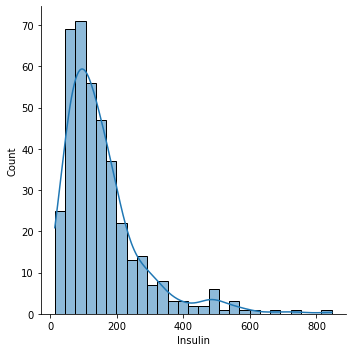

In [441]:
# sns.distplot(train["Insulin"])
sns.displot(data=train, x="Insulin", kde=True)

<AxesSubplot:xlabel='Insulin'>

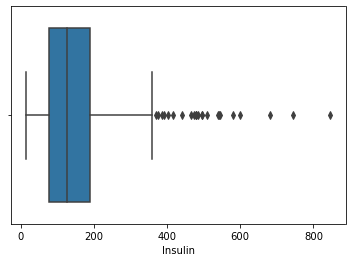

In [442]:
sns.boxplot(data=train, x="Insulin")

In [443]:
desc = train["Insulin"].describe()
desc

count    394.000000
mean     155.548223
std      118.775855
min       14.000000
25%       76.250000
50%      125.000000
75%      190.000000
max      846.000000
Name: Insulin, dtype: float64

In [444]:
# IQR =  3IQR - 1IQR
# OUT > 3IQR + (IQR * 1.5)
IQR = desc.loc["75%"] - desc.loc["25%"]
print(IQR)
OUT = desc.loc["75%"] + (IQR * 1.5)
print(OUT)

113.75
360.625


In [445]:
train[train["Insulin"]>OUT].shape

(24, 9)

In [446]:
print(train.shape)
train=train[train["Insulin"]<OUT]
train

(394, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
6,3,78,50,32,88,31.0,0.248,26,1
14,5,166,72,19,175,25.8,0.587,51,1
16,0,118,84,47,230,45.8,0.551,31,1
...,...,...,...,...,...,...,...,...,...
751,1,121,78,39,74,39.0,0.261,28,0
755,1,128,88,39,110,36.5,1.057,37,1
760,2,88,58,26,16,28.4,0.766,22,0
763,10,101,76,48,180,32.9,0.171,63,0



## 학습, 예측에 사용할 컬럼

In [447]:
# feature_names 라는 변수에 학습과 예측에 사용할 컬럼명을 가져옵니다.

feature_names=test.columns.tolist()
feature_names.remove("Insulin")
feature_names

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

## 정답값이자 예측해야 될 값

In [448]:
# label_name 이라는 변수에 예측할 컬럼의 이름을 담습니다.

label_name = "Insulin"
label_name

'Insulin'

## 학습, 예측 데이터셋 만들기

In [449]:
# 학습 세트 만들기 예) 시험의 기출문제
X_train=train[feature_names]
X_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89,66,23,28.1,0.167,21,0
4,0,137,40,35,43.1,2.288,33,1
6,3,78,50,32,31.0,0.248,26,1
14,5,166,72,19,25.8,0.587,51,1
16,0,118,84,47,45.8,0.551,31,1
...,...,...,...,...,...,...,...,...
751,1,121,78,39,39.0,0.261,28,0
755,1,128,88,39,36.5,1.057,37,1
760,2,88,58,26,28.4,0.766,22,0
763,10,101,76,48,32.9,0.171,63,0


In [450]:
# 정답 값을 만들어 줍니다. 예) 기출문제의 정답
y_train=train[label_name]
y_train

3       94
4      168
6       88
14     175
16     230
      ... 
751     74
755    110
760     16
763    180
765    112
Name: Insulin, Length: 370, dtype: int64

In [451]:
# 예측에 사용할 데이터세트를 만듭니다. 예) 실전 시험 문제

X_test=test[feature_names]
X_test

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,33.6,0.627,50,1
1,1,85,66,29,26.6,0.351,31,0
2,8,183,64,0,23.3,0.672,32,1
5,5,116,74,0,25.6,0.201,30,0
7,10,115,0,0,35.3,0.134,29,0
...,...,...,...,...,...,...,...,...
761,9,170,74,31,44.0,0.403,43,1
762,9,89,62,0,22.5,0.142,33,0
764,2,122,70,27,36.8,0.340,27,0
766,1,126,60,0,30.1,0.349,47,1


In [452]:
# 예측의 정답값 예) 실전 시험 문제의 정답
y_test=test[label_name]
y_test

0      0
1      0
2      0
5      0
7      0
      ..
761    0
762    0
764    0
766    0
767    0
Name: Insulin, Length: 374, dtype: int64

## 머신러닝 알고리즘 가져오기

In [453]:
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
estimators= [DecisionTreeRegressor(random_state=42), RandomForestRegressor(random_state=42), GradientBoostingRegressor(random_state=42)]

estimators

[DecisionTreeRegressor(random_state=42),
 RandomForestRegressor(random_state=42),
 GradientBoostingRegressor(random_state=42)]

In [454]:
max_depth=np.random.randint(5, 30, 10)
max_depth

array([25, 19, 11, 11, 27, 26, 22, 19,  7, 25])

In [455]:
max_features=np.random.uniform(0.3, 1.0, 10)
max_features

array([0.77096536, 0.68824603, 0.64650799, 0.71699445, 0.61813705,
       0.46398282, 0.67913766, 0.74370513, 0.80079015, 0.49253417])

In [456]:
results=[]
for estimator in estimators:
    result=[]
    result.append(estimator.__class__.__name__)
    results.append(result)
    
pd.DataFrame(results)

,0
0,DecisionTreeRegressor
1,RandomForestRegressor
2,GradientBoostingRegressor


In [457]:
from sklearn.model_selection import RandomizedSearchCV
param_distributions= {"max_depth":max_depth, "max_features":max_features}
results=[]
for estimator in estimators:
    max_depth=np.random.randint(5, 30, 100)
    max_features=np.random.uniform(0.3, 1.0, 100)
    result=[]
    
    regressor=RandomizedSearchCV(estimator,
        param_distributions,
        n_iter=100,
        scoring=None,
        n_jobs=None,
        refit=True,
        cv=5,
        verbose=3,
        random_state=42)
    regressor.fit(X_train, y_train)
    result.append(estimator.__class__.__name__)
    result.append(regressor.best_params_)
    result.append(regressor.best_estimator_)
    result.append(regressor.best_score_)
    result.append(regressor.cv_results_)
    results.append(result)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END max_depth=25, max_features=0.770965361434644;, score=-0.250 total time=   0.0s
[CV 2/5] END max_depth=25, max_features=0.770965361434644;, score=-0.140 total time=   0.0s
[CV 3/5] END max_depth=25, max_features=0.770965361434644;, score=0.041 total time=   0.0s
[CV 4/5] END max_depth=25, max_features=0.770965361434644;, score=0.153 total time=   0.0s
[CV 5/5] END max_depth=25, max_features=0.770965361434644;, score=-0.513 total time=   0.0s
[CV 1/5] END max_depth=25, max_features=0.688246030062413;, score=0.033 total time=   0.0s
[CV 2/5] END max_depth=25, max_features=0.688246030062413;, score=-0.487 total time=   0.0s
[CV 3/5] END max_depth=25, max_features=0.688246030062413;, score=-0.018 total time=   0.0s
[CV 4/5] END max_depth=25, max_features=0.688246030062413;, score=-0.049 total time=   0.0s
[CV 5/5] END max_depth=25, max_features=0.688246030062413;, score=-0.413 total time=   0.0s
[CV 1/5] END max_dep

In [458]:
df_cv=pd.DataFrame(results)
df_cv.columns=["model","params","estimator","score","cv_result"]
df_cv

,model,params,estimator,score,cv_result
0,DecisionTreeRegressor,"{'max_features': 0.4639828234104336, 'max_dept...","DecisionTreeRegressor(max_depth=7, max_feature...",0.068158,"{'mean_fit_time': [0.002025127410888672, 0.002..."
1,RandomForestRegressor,"{'max_features': 0.4639828234104336, 'max_dept...","(DecisionTreeRegressor(max_depth=7, max_featur...",0.344289,"{'mean_fit_time': [0.11891937255859375, 0.1116..."
2,GradientBoostingRegressor,"{'max_features': 0.770965361434644, 'max_depth...",([DecisionTreeRegressor(criterion='friedman_ms...,0.292220,"{'mean_fit_time': [0.09042048454284668, 0.0806..."


In [459]:
best_estimator=df_cv.loc[1,"estimator"]
best_estimator

RandomForestRegressor(max_depth=7, max_features=0.4639828234104336,
                      random_state=42)

In [460]:
best_estimator.fit(X_train,y_train)

RandomForestRegressor(max_depth=7, max_features=0.4639828234104336,
                      random_state=42)

## cross validation 으로 학습 세트의 오차 측정하기

In [461]:
from sklearn.model_selection import cross_val_predict
y_predict=cross_val_predict(best_estimator, X_train, y_train, cv=5, verbose=3, n_jobs=-1)
y_predict[:5]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


array([ 60.69740817, 171.19985494, 100.062401  , 152.08852503,
       176.5009325 ])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


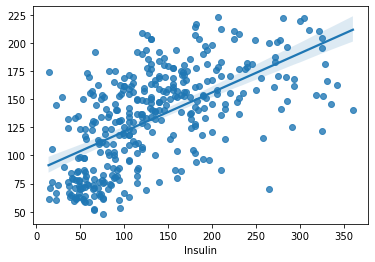

In [462]:
# regplot 으로 결과 값을 비교합니다.

sns.regplot(y_train, y_predict)
plt.show()

In [463]:
# r2_score 를 구합니다.

from sklearn.metrics import r2_score

r2_score(y_train, y_predict)

0.3583705945778839

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


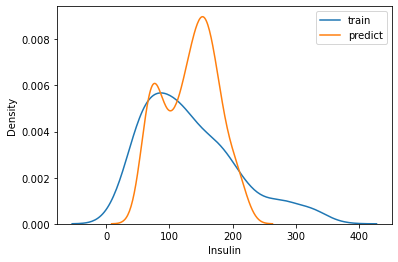

In [464]:
# distplot으로 정답값과 예측값의 분포를 그립니다.
sns.distplot(y_train,hist=False, label="train")
sns.distplot(y_predict,hist=False, label="predict")
plt.legend()
plt.show()


## 오차 구하기

In [465]:
# MAE
# 86
# 77.55
# 62.05
# 44.385 - RandomSearchCV
error=abs(y_train-y_predict)
error.mean()

44.46116336089672

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


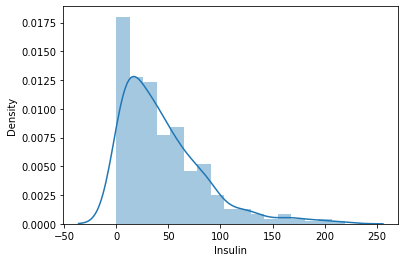

In [466]:
sns.distplot(error)
plt.show()

In [467]:
error.describe()

count    370.000000
mean      44.461163
std       39.478652
min        0.150011
25%       13.981504
50%       35.178905
75%       62.442258
max      219.473938
Name: Insulin, dtype: float64

In [468]:
# RMSE
# 126.895
# 114.077 (Insulin<600)
# 84        (Insulin<OUT)
# 59.68     RandomSearchCV
np.sqrt(((y_train - y_predict) ** 2).mean())

59.42345213026226

## 트리 알고리즘 분석하기
* 의사결정나무를 시각화 합니다.
* 피처의 중요도를 구합니다.

In [469]:
from sklearn.model_selection import RandomizedSearchCV
param_distributions= {"max_depth":max_depth, "max_features":max_features}
results=[]
for estimator in estimators:
    max_depth=np.random.randint(5, 30, 100)
    max_features=np.random.uniform(0.3, 1.0, 100)
    result=[]
    
    regressor=RandomizedSearchCV(estimator,
        param_distributions,
        n_iter=100,
        scoring=None,
        n_jobs=None,
        refit=True,
        cv=5,
        verbose=3,
        random_state=42)
    regressor.fit(X_train, y_train)
    result.append(estimator.__class__.__name__)
    result.append(regressor.best_params_)
    result.append(regressor.best_estimator_)
    result.append(regressor.best_score_)
    result.append(regressor.cv_results_)
    results.append(result)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END max_depth=13, max_features=0.9436074657626001;, score=-0.084 total time=   0.0s
[CV 2/5] END max_depth=13, max_features=0.9436074657626001;, score=-0.162 total time=   0.0s
[CV 3/5] END max_depth=13, max_features=0.9436074657626001;, score=-0.048 total time=   0.0s
[CV 4/5] END max_depth=13, max_features=0.9436074657626001;, score=-0.214 total time=   0.0s
[CV 5/5] END max_depth=13, max_features=0.9436074657626001;, score=-0.403 total time=   0.0s
[CV 1/5] END max_depth=14, max_features=0.9971853572266549;, score=-0.238 total time=   0.0s
[CV 2/5] END max_depth=14, max_features=0.9971853572266549;, score=-0.400 total time=   0.0s
[CV 3/5] END max_depth=14, max_features=0.9971853572266549;, score=0.049 total time=   0.0s
[CV 4/5] END max_depth=14, max_features=0.9971853572266549;, score=0.028 total time=   0.0s
[CV 5/5] END max_depth=14, max_features=0.9971853572266549;, score=-0.518 total time=   0.0s
[CV 1/5] 

<AxesSubplot:>

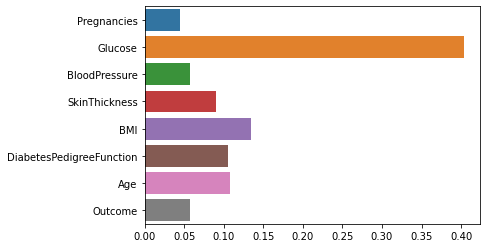

In [470]:
sns.barplot(x=best_estimator.feature_importances_,y= feature_names)

In [471]:
# 피처의 중요도를 추출하기
best_estimator.feature_importances_

array([0.04405408, 0.40304867, 0.05731369, 0.09065531, 0.13418634,
       0.10550219, 0.10825769, 0.05698204])

## 예측
* 실전 시험문제(X_test)라고 보면 됩니다. 우리가 정답을 직접 예측합니다.
* Insulin 이 0인 값을 예측 했기 때문에 정답을 알 수 없습니다.
* 따라서 점수는 train set로 측정한 값을 참고합니다.

In [472]:
x_test_predict=best_estimator.predict(X_test)
x_test_predict[:5]

array([188.84245654,  66.13253187, 181.49139736, 142.82079964,
       159.37125581])

In [473]:
train.groupby("Outcome")["Insulin"].describe()

,count,mean,std,min,25%,50%,75%,max
Outcome,,,,,,,,
0,254.0,115.917323,69.844697,15.0,64.25,100.0,151.00,342.0
1,116.0,169.163793,70.789454,14.0,124.25,160.0,207.75,360.0


In [474]:
test["Insulin"]= x_test_predict
test.groupby("Outcome")["Insulin"].describe()

,count,mean,std,min,25%,50%,75%,max
Outcome,,,,,,,,
0,236.0,129.628908,37.666286,54.169851,98.687496,134.167371,160.983145,229.358918
1,138.0,172.589019,26.437355,100.512096,158.304918,174.824644,189.254731,242.813880


<AxesSubplot:xlabel='Outcome', ylabel='Insulin'>

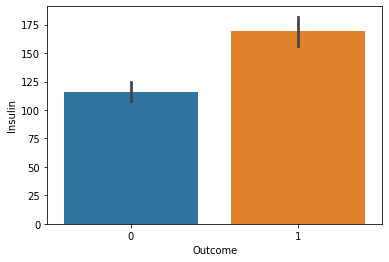

In [475]:
# Insulin 평균값을 출력
sns.barplot(data=train, x="Outcome", y="Insulin")

<AxesSubplot:xlabel='Outcome', ylabel='Insulin'>

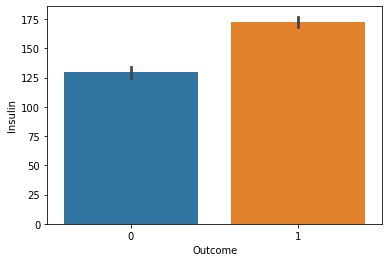

In [476]:
# 예측값
sns.barplot(data=test, x="Outcome", y="Insulin")

# 14 예측값을 CSV 파일로 저장하기

In [481]:
df.loc[df["Insulin"]==0, "Insulin"]=test["Insulin"]

In [482]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,188.842457,33.6,0.627,50,1
1,1,85,66,29,66.132532,26.6,0.351,31,0
2,8,183,64,0,181.491397,23.3,0.672,32,1
3,1,89,66,23,94.000000,28.1,0.167,21,0
4,0,137,40,35,168.000000,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180.000000,32.9,0.171,63,0
764,2,122,70,27,161.010514,36.8,0.340,27,0
765,5,121,72,23,112.000000,26.2,0.245,30,0
766,1,126,60,0,172.112971,30.1,0.349,47,1


In [479]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [480]:
df.to_csv("../data/diabetes_fill_insulin.csv",index=False)